In [28]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net, MLP

In [29]:
n_epoch = 100000 #エポック
batchsize = 3000 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 200 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [30]:
xp = cuda.cupy if use_gpu is True else np

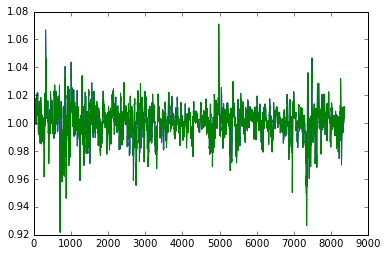

In [31]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append(row[7])
    train_data_y.append(row[7])
raw_data = np.asarray(train_data_x, dtype=np.float32)
train_data_x = raw_data[:-1]
train_data_y = raw_data[1:]
plt.plot(train_data_x)
plt.plot(train_data_y)

In [32]:
#ネットワークを試す関数
def evaluate(model, x):
    output = []
    evaluator = model.copy()
    for i in range(len(x)):
        t = evaluator.predict(chainer.Variable(xp.asarray([[x[i]]])))
        output.append(t.data[0])
    return output

In [33]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 1000 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data / length))
        loss.append(loss_data / length)
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 1000, error 0.00013915475574322045
epoch 2000, error 4.4055257603758946e-05
epoch 3000, error 2.2338168491842225e-05
epoch 4000, error 3.7956465348543134e-06
epoch 5000, error 2.673077233339427e-06
epoch 6000, error 3.041993977603852e-06
epoch 7000, error 3.282740863141953e-06
epoch 8000, error 3.057168214581907e-06
epoch 9000, error 2.153565446860739e-06
epoch 10000, error 2.658625362528255e-06
epoch 11000, error 3.039596776943654e-06
epoch 12000, error 2.964684881590074e-06
epoch 13000, error 2.0981735815439606e-06
epoch 14000, error 2.0797315301024355e-06
epoch 15000, error 2.6553504994808463e-06
epoch 16000, error 4.2170413507847115e-06
epoch 17000, error 8.984154192148708e-06
epoch 18000, error 2.1602088509098394e-06
epoch 19000, error 2.8637241484830156e-06
epoch 20000, error 2.45403975895897e-06
epoch 21000, error 2.3561028683616314e-06
epoch 22000, error 1.8552242408986785e-06
epoch 23000, error 2.062309022221598e-06
epoch 24000, error 2.149582087440649e-06
epoch 25000, e

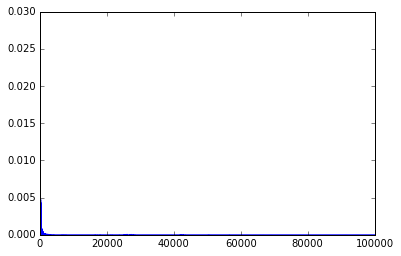

In [34]:
plt.plot(loss[10:])

In [35]:
output = evaluate(model,train_data_x)

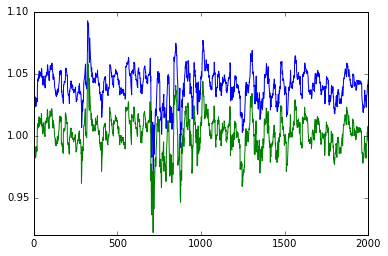

In [39]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

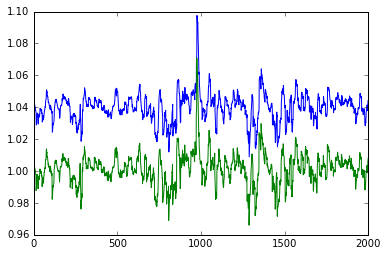

In [40]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])